# Annotation mapping

In this example, we show how to use {func}`~moscot.problems.space.MappingProblem.annotation_mapping`.

In scenarios involving datasets with varying annotation levels, only one dataset might be fully annotated, or the annotation quality may differ, with one being more detailed or reliable than the other. The {func}`~moscot.problems.space.MappingProblem.annotation_mapping` function facilitates annotation transfer between datasets through a created mapping, ensuring consistency across annotations.

:::{seealso}
- See {doc}`../../tutorials/400_spatial_mapping` how to use the {class}`~moscot.problems.space.MappingProblem` for mapping single-cell to spatial data.
- See {doc}`../plotting/200_cell_transitions` on how to compute and plot cell transitions.
:::

## Imports and data loading

In [1]:
import warnings

from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

import moscot as mt
from moscot import datasets
from moscot.problems.space import MappingProblem

import numpy as np

import seaborn as sns

import scanpy as sc

The {func}`~moscot.datasets.drosophila` dataset is an embryo of Drosophila melanogaster dataset described in {cite}`Li-spatial:22` with minimal pre-processing. `adata_sc` is the scRNA-seq and `adata_sp` is the spatial dataset.

In [2]:
adata_sc = datasets.drosophila(spatial=False)
adata_sp = datasets.drosophila(spatial=True)
adata_sc, adata_sp

(AnnData object with n_obs × n_vars = 1297 × 2000
     obs: 'n_counts'
     var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 3039 × 82
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'log1p', 'pca'
     obsm: 'X_pca', 'spatial'
     varm: 'PCs'
     layers: 'counts')

## Cluster the data

Leiden clustering is a widely-used algorithm for annotating cell types, grouping similar cells based on their gene expression profiles or other relevant features.
Here, leiden clusters serve as an effective approximation for cell types or any other group annotations utilized in the analysis.

In [3]:
sc.pp.neighbors(adata_sc)
sc.pp.neighbors(adata_sp)

In [4]:
sc.tl.umap(adata_sc)
sc.tl.umap(adata_sp)

In [5]:
sc.tl.leiden(adata_sc)
sc.tl.leiden(adata_sp)
adata_sc.obs.leiden = adata_sc.obs.leiden.astype("category")
adata_sp.obs.leiden = adata_sp.obs.leiden.astype("category")

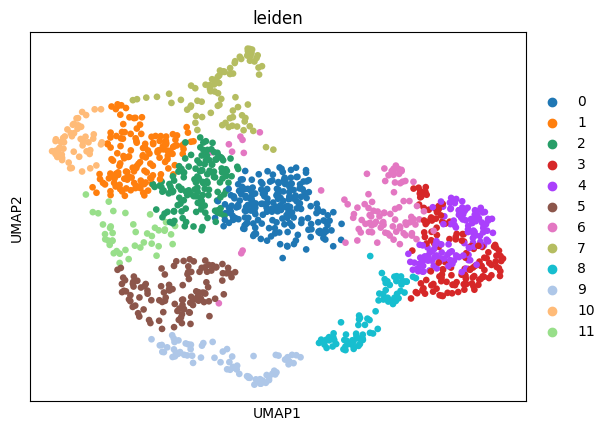

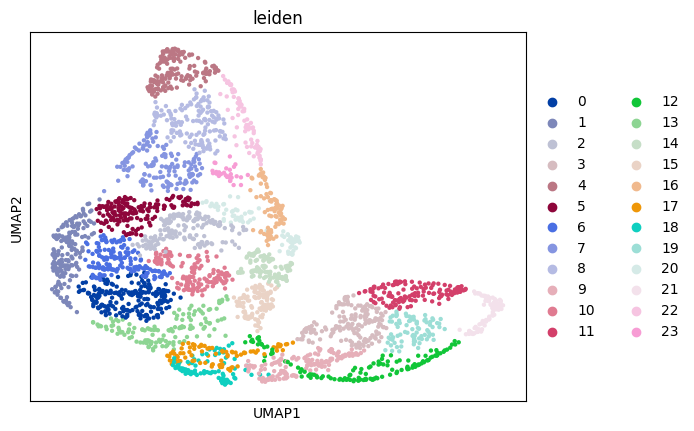

In [6]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color="leiden")

## Prepare and solve the problem

In [7]:
mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp)

In [8]:
mp = mp.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"}, kwargs={"callback_kwargs": "local_pca"}
).solve()

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3039, 1297)].                                          


## Create the annotation mapping of leiden clusters

In this case, the target is `adata_sc` and the source is `adata_sp`. So, in order to map the leiden cluster annotation from single cell to spatial data, we need to pass `forward=False`.

First, we create the annotation mapping using "max" mode. This mode transfers the label of the cell with the highest matching probability.

In [9]:
anno_map_max = mp.annotation_mapping(
    "max",
    "leiden",
    source="src",
    forward=False,
    batch_size=256,
)
adata_sp.obs["leiden_max"] = anno_map_max["leiden"].values
adata_sp.obs["leiden_max"] = adata_sp.obs["leiden_max"].astype("category")

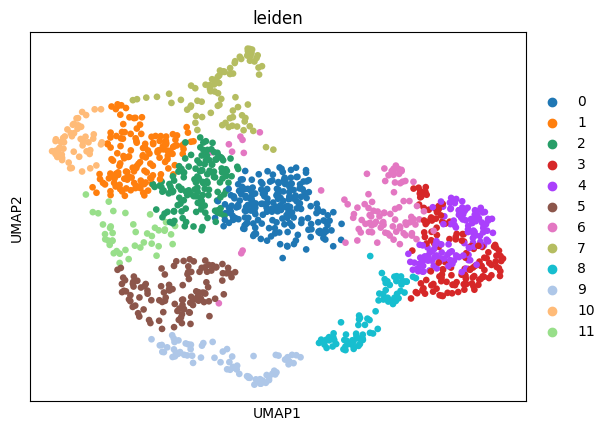

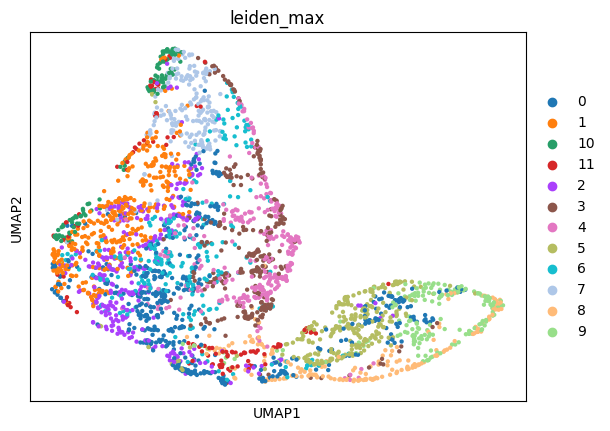

In [10]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color=["leiden_max"])

Then, we create the annotation mapping using the "sum" mode. It groups the cells by cell type and transfers the label with the highest total matching probability.

In [11]:
anno_map_sum = mp.annotation_mapping(
    "sum",
    "leiden",
    source="src",
    forward=False,
    batch_size=256,
)
adata_sp.obs["leiden_sum"] = anno_map_sum["leiden"].values
adata_sp.obs["leiden_sum"] = adata_sp.obs["leiden_sum"].astype("category")

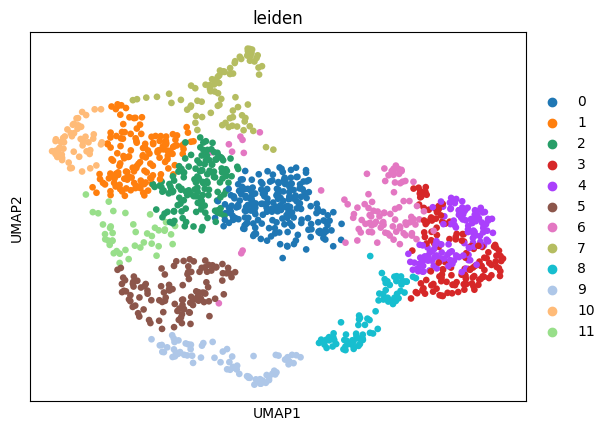

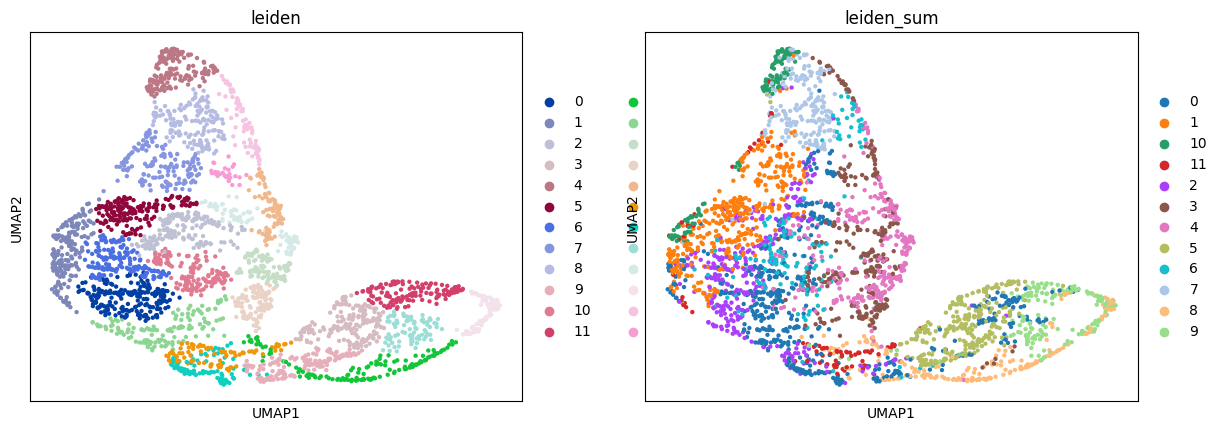

In [12]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color=["leiden", "leiden_sum"])

Compare the resulting mapping of different modes:

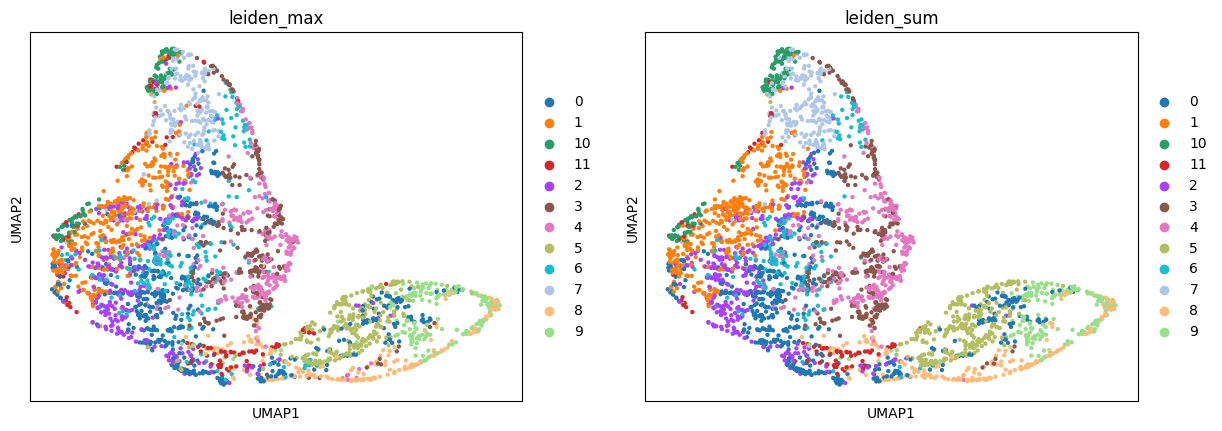

In [13]:
sc.pl.umap(adata_sp, color=["leiden_max", "leiden_sum"])

And calculate the fraction of cells that got the same label assigned by `"max"` and `"sum"` modes:

In [20]:
adata_sp[adata_sp.obs["leiden_max"] == adata_sp.obs["leiden_sum"]].shape[
    0
] / adata_sp.shape[0]

0.8644290885159592

Around 86% of the cells got the same label in both modes.